Tworząc ten notatnik czerpałem garściami z fenomenalnego filmu Andreja Karpathy: [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY&), który omawiał artykuł/badanie "Attention is all you need" z 2017 r.: [Attention is all you need](https://arxiv.org/pdf/1706.03762)

W tym notatniku, zaczynając od podstaw, zbudujemy transformer korzystając wyłącznie z podstawowych bloków zawartych w PyTorch:

- będziemy tworzyć własne moduły, dziedziczące z klasy **nn.Module**
- oczywiście niezbędna będzie fully-connected layer: **nn.Linear**
- potrzebna nam będzie także warstwa **nn.Dropout** do walki z overfittingiem

Wszystkie bardziej skomplikowane moduły zbudujemy korzystając z wyżej wymienionych "klocków Lego" oraz z nieocenionego API PyTorch dotyczącego Tensorów i backpropagation.

Przejdziemy przez dziewięć wersji modelu, który stopniowo będziemy zamieniać ze zwykłego look-up table prawdopodobieństw na (niemal) w pełni odpowiadający temu z "attention is all you need" transformer.

In [164]:
import gdown  # aby pobrać zbiór danych z dysku google
import os.path

from torch import tensor
import torch
import torch.nn.functional as F

Zbiór danych jest dowolny tak długo, jak długo jest tekstowy. 
Na początek naszy zbiór będzie bardzo prosty - jeden plik tekstowy zawierający dzieła Szekspira.

Zbiór danych jest pobierany z mojego dysku google (jeśli nie jest już pobrany) a następnie wczytywany jako zwykły plik tekstowy

In [165]:
dataset_link = "https://drive.google.com/uc?id=1TQjhbN1jrQx7eMgySFkMfwahh7IZy2a8"
dataset_path = "data/Shakespeare.txt"
if not os.path.isfile(dataset_path):
    print("Downloading dataset...")
    gdown.download(dataset_link, dataset_path)
    print("Done!")
else:
    print("Dataset is already downloaded")
    
with open(dataset_path, "r", encoding="utf-8") as f:
    whole_text = f.read()

Dataset is already downloaded


In [166]:
print(f"Length of the dataset: {len(whole_text)}")

Length of the dataset: 1115394


"Podejrzymy" początek naszego zbioru danych

In [167]:
print(whole_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



Nasz LLM, jak każda inna sieć neuronowa, operuje na liczbach. Potrzebny nam jest enkoder, który pozwoli zamienić tekst na liczby oraz dekoder, który odwróci działanie enkodera.

Aby zdefiniować jakikolwiek enkoder potrzebny nam jest kompletny zbiór słownictwa. Aby zachować prostotę, ograniczymy się tutaj do pojedyńczych liter - jedna litera będzie jednym tokenem. Niemniej należy pamiętać, że w bardziej zaawansowanych modelach dużo lepiej działają tokeny składające się ze zlepków liter.

Podział tekstu na tokeny jest wielkim problemem samym w sobie i nie będziemy się w niego zagłębiać w ramach tego projektu

In [168]:
vocab = sorted(list(set(whole_text)))  # set zapewnia unikalność znaków, lista daje się posortować
vocab_size = len(vocab)
print(f"Vocab: {"".join(vocab)}")
print(f"Vocab len: {len(vocab)}")

Vocab: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab len: 65


In [169]:
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for i, char in enumerate(vocab)}
encode = lambda s: [stoi[c] for c in s]  # zamienia string na listę liczb
decode = lambda l: "".join(itos[i] for i in l)

print(encode("Hello world!"))
print(decode(encode("Hello world!")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
Hello world!


Wczytajmy cały zbiór danych (w końcu waży tylko 1MB) do tensora

In [170]:
data = tensor(encode(whole_text))
print(f"{data.shape = }, {data.dtype = }")
print(data[:100])

data.shape = torch.Size([1115394]), data.dtype = torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


Podzielimy nasz zbiór danych na część treningową i testową, aby móc ocenić, na ile dobrze model uczy się ogólnych tendencji, a nie po prostu "zapamiętuje".  Zazwyczaj zbiory danych dzielone są losowo, tak, aby żadna z "części" takiego zbioru nie była słabiej reprezentowana. 

W tym przypadku wyciąganie wyrazów ze środka tekstu nie będzie dobrą metodą, ponieważ w analizie tekstu kluczowy jest kontekst. W związku z tym tekst zostanie "przedzielony" na dwie części

In [171]:
train_to_all_ratio = 0.85
n = int(train_to_all_ratio * data.numel())
train_data, test_data = data[:n], data[n:]
print(f"{len(train_data) = }, {len(test_data) = }")

len(train_data) = 948084, len(test_data) = 167310


Przy ćwiczeniu modeli językowych nie można podać całego zbioru danych na raz. Tekst jest podawany w losowo wybieranych blokach.
Wielkość takiego bloku jest ustalona i jest jednocześnie **maksymalnym** rozmiarem kontekstu dostępnego dla naszego modelu. Dla każdego bloku model jest ćwiczony dla wszystkich kontekstów zaczynając od 1 a kończąc na `block_size`.

Zobrazujmy to za pomocą pętli:

In [172]:
context_size = 7
def show_context():
    x = train_data[:context_size]
    y = train_data[1:context_size + 1]  # cel jest przesunięty o 1 względem danej treningowej
    for i in range(context_size):
        context = x[:i+1]  # do i-tego znaku włącznie
        target = y[i]
        print(f"For input {context} the target is {target}")
show_context()

For input tensor([18]) the target is 47
For input tensor([18, 47]) the target is 56
For input tensor([18, 47, 56]) the target is 57
For input tensor([18, 47, 56, 57]) the target is 58
For input tensor([18, 47, 56, 57, 58]) the target is 1
For input tensor([18, 47, 56, 57, 58,  1]) the target is 15
For input tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47


Ćwiczenie modelu na wszystkich rozmiarach kontekstu, oprócz oczywistej zalety w postaci szybkości uzyskiwania danych (sekwencja tekstu i tak jest pozyskana), pozwala nauczyć model działania także przy krótszych kontekstach. W naszym przypadku kontekst nie będzie duży, jednak w przypadku takich modeli jak GPT-3.5 czy GPT-4 rozmiar kontekstu może wynosić nawet setki tysięcy tokenów i większość zapytań nie będzie tak długa

Karty graficzne są bardzo dobre w zrównoleglaniu obliczeń - dlatego podczas korzystania z modeli podaje im się wiele niezależnych wartości, które są przetwarzane jednocześnie. Zbiór wszystkich takich wartości nazywany jest batchem

In [173]:
batch_size = 64

rng = torch.Generator()
rng.manual_seed(42)

def get_random_batch(split: str, batch_size:int, block_size: int, my_rng: torch.Generator) -> (torch.Tensor, torch.Tensor):
    """
    Returns a random batch of data - tensor of shape (batch_size, block_size). 
    :param split: can be either "train" or "test". When train the train dataset is used
    :returns: A tuple of two tensors - first with training data and second with labels/targets
    """
    if split == "train": my_data = train_data
    elif split == "test": my_data = test_data
    else: raise ValueError(f"Expected either `train` or `test` for the split argument, got {split} instead")
    idx = torch.randint(len(my_data) - block_size, size=(batch_size,), generator=my_rng)
    # randint jest end-exclusive, dlatego nie trzeba modyfikować indeksów mimo że target jest i+1
    x = torch.stack([data[i: i+block_size] for i in idx])
    y = torch.stack([data[i+1: i+block_size+1] for i in idx])
    return x, y

def show_random_batch():
    xb, yb = get_random_batch("train", batch_size, context_size, rng)
    print(f"Data shape: {xb.shape}")
    print(f"Label shape: {yb.shape}")

Zwracam uwagę, że tutaj dane treningowe oraz targety mają ten sam kształt - dla każdego jednego znaku chcemy wiedzieć, jaki znak jest następny.

Można zauważyć, że jest to niepotrzebne duplikowanie informacji, ponieważ dla wszystkich znaków oprócz ostatniego jest ona zawarta już w danych treningowych. To prawda, jednak przy ilości obliczeń wykonywanych przez transformery nie robi to zauważalnej różnicy w wydajności treningu, a kod jest bardziej czytelny

Zaczniemy od najprostszej sieci neuronowej, czyli modelu bigramowego. 

Model bigramowy dla każdego tokenu zczytuje prawdopodobieństwa / logity następnego tokenu ze zwykłej lookup-table. W PyTorch jest już wbudowany moduł, który świetnie może posłużyć za taki lookup-table: torch.nn.Embedding. Obiecałem jednak budowę od podstaw, dlatego najpierw zdefiniujmy własny moduł służący jako lookup table.

Zwracam jednak uwagę, że "domowa" implementacja warstwy Embedding jako funkcję gradientu posiada zwykłe IndexBackward.
Warstwa nn.Embedding posiada gradient EmbeddingBackward, który jest zoptymalizowany do działań w modułach, gdzie przy każdym backward pass tylko część wag jest aktualizowana i w tym przypadku będzie dużo szybszy od zwykłego IndexBackward.
Dlatego przy budowaniu większych modeli zalecam jednak korzystać z pracy twórców PyTorcha a nie samemu wymyślać koło od nowa.

In [174]:
import torch.nn as nn
class MyEmbedding(nn.Module):
    def __init__(self, num_embeddings: int, one_embedding_size: int):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((num_embeddings, one_embedding_size), dtype=torch.float))
        
    def forward(self, input_indices):
        return self.weights[input_indices]    

Zbudujmy teraz nasz model bigramowy. Działanie tego modelu jest bardzo proste - dla każdego z tokenów w słowniku w warstwie Embedding (która jest stworzona do czegoś zupełnie innego, ale świetnie się nadaje też do naszych celów) przechowywane są logity wszystkich pozostałych tokenów. Dlatego "predykcja" z wykorzystaniem takiej sieci to zwykłe odczytanie z wielkiej tablicy prawdopodobieństw który token wybrać jako następny

In [175]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size: int):
        super().__init__()
        self.embedding_table = MyEmbedding(vocab_size, vocab_size)
        
    def forward(self, input_indices):
        """Przyjmuje tensor o wymiarach (*) i zwraca odczytany z lookup-table tensor o wymiarach (*, one_embedding_size)"""
        logits = self.embedding_table(input_indices)
        return logits
    
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            logits = self(current_context) # (batch, czas, embedding_dim)
            # do predykcji wykorzystujemy tylko ostatni token kontekstu, więc wybieramy tylko ostatnią wartość wymiaru czas
            # (wybaczcie brak lepszej nazwy)
            logits = logits[:, -1, :]  
            # korzystając z softmaxu zamieniamy ostatni wymiar logitów na rozkład prawdopodobieństwa
            probabilities = F.softmax(logits, dim=-1)  
            # po zamianie na rozkład prawdopodobieństwa losujemy wartość z tego rozkładu
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
   
model = BigramModel(vocab_size=vocab_size)
         
train_older_models = input("Do you want to train all model versions [Y]. If not, then only the newest model will be trained"
                           "and evaluated")
train_older_models = True if train_older_models.lower() == "y" else False
if train_older_models is True:
    xb, yb = get_random_batch("train", batch_size, context_size, rng)
    simple_output = model(xb)
    print(f"Input shape: {xb.shape}  output shape: {simple_output.shape}")
    generated_output = model.generate(xb, 100)[0].cpu()
    print(f"Generated 100 new tokens, output shape: {generated_output.shape}")
    print(20*"-" + "\n" + f"Generated text: {decode(generated_output.tolist())}")

Input shape: torch.Size([64, 7])  output shape: torch.Size([64, 7, 65])
Generated 100 new tokens, output shape: torch.Size([107])
--------------------
Generated text: to see EJ$ Fxet&cmVWBsaGH$krbep BwmPSVhHp
oQvVzkFxQxHLtP!GdLWu&ZomlLpp3bc,n:orq,Fp&P'N'KS3uQtRzEJX,Qxz'CFFt


Jak widać na początku nasz model generuje znaki całkowicie losowo i jedyną częścią tego tekstu, która ma jakikolwiek sens, jest zapodany przez nas na początku kontekst

Jeżeli to możliwe, przenieśmy nasz model na kartę graficzną, znacznie to przyspieszy trening

In [176]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = data.to(device)
if train_older_models is True:
    model = model.to(device)


Nasz model jest już gotowy do treningu, stwórzmy teraz optimizer oraz przećwiczmy nasz model.

Z perspektywy autorów "Attention is all you need" zajrzymy w przyszłość i wykorzystamy optimizer AdamW, wprowadzony po raz pierwszy w 2019 roku w artykule "Decoupled weight decay regularization". Różni się od podstawowego Adam-a tym, że rozdziela weight decay od obliczanego gradientu, zamiast tego jest stosowany bezpośrednio na wagach. Lepiej od zwykłego Adama radzi sobie z generalizowaniem i jest obecnie standardowym go-to w wielu modelach językowych.

Utworzymy także funkcję evaluate_model(), która będzie oceniała model zarówno na danych treningowych, jak i testowych.
Porównanie wyników z danych treningowych i testowych pozwoli wychwycić moment, w którym model zacznie się przetrenowywać.

In [177]:
@torch.no_grad()
def evaluate_model(m, split: str, n_samples: int) -> float:
    xb, yb = get_random_batch(split, n_samples, context_size, rng)
    m.eval()
    logits = m(xb)
    logits = logits.view(batch_size * context_size, vocab_size)
    yb = yb.view(batch_size * context_size)
    loss = F.cross_entropy(logits, yb)
    m.train()
    return loss.item()

def train_model(m, n_iter, context_size=context_size):
    optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
    for i in range(n_iter):
        xb, yb = get_random_batch("train", batch_size, context_size, rng)
        logits = m(xb)
        # musimy nieco zmienić kształt, ponieważ funkcja cross_entropy oczekuje kształtu (Batch, Channels) dla Inputu oraz (Batch,) dla Targetu
        # obecnie nasz input ma kształt (Batch, context_size, embedding_dim) a target (Batch, context_size). Musimy złączyć wymiary Batch oraz context w jeden
        logits = logits.view(batch_size * context_size, vocab_size)
        yb = yb.view(batch_size * context_size)
        loss = F.cross_entropy(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i  % (n_iter // 10) == 0:
            train_loss = evaluate_model(m, "train", batch_size)
            test_loss = evaluate_model(m, "test", batch_size)
            print(f"Iteration {i + 1} train loss: {train_loss:.3f} | test loss: {test_loss:.3f}")
        elif i == n_iter - 1:
            train_loss = evaluate_model(m, "train", batch_size)
            test_loss = evaluate_model(m, "test", batch_size)
            print(f"Final iteration train loss: {train_loss:.3f} | test loss: {test_loss:.3f}")
if train_older_models is True:
    train_model(model, 1_000)

Iteration 1 train loss: 4.747 | test loss: 4.692
Iteration 101 train loss: 4.541 | test loss: 4.665
Iteration 201 train loss: 4.433 | test loss: 4.449
Iteration 301 train loss: 4.436 | test loss: 4.337
Iteration 401 train loss: 4.256 | test loss: 4.271
Iteration 501 train loss: 4.237 | test loss: 4.235
Iteration 601 train loss: 4.027 | test loss: 4.060
Iteration 701 train loss: 3.953 | test loss: 4.004
Iteration 801 train loss: 3.835 | test loss: 3.879
Iteration 901 train loss: 3.855 | test loss: 3.753
Final iteration train loss: 3.738 | test loss: 3.660


Spróbujmy teraz wygenerować coś z naszego modelu

In [178]:
if train_older_models is True:
    generated_output = model.generate(current_context=torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=200)
    # zero odpowiada znakowi '\n'
    print(decode(generated_output.squeeze().tolist()))


UzSTNGlV;IagssuVz;HgzSs$OHY??veu Jgm'bohVSjQN'QI, n!$UQ&r
ACEDnTQvefZW-
Saxf
uPrimV.vSeXrc?i:K.ppGCWa?Yedk;zeFFuQT,rcMTujWEJSUenTuN.YOTDpeeu hciidKlunoX,?epueeWuQTy-
x:zeePfGU. hyuQSco m;E, iRGzcoAad 


Efekty są znacznie lepsze niż poprzednim razem, prawda? Teraz wygląda to jak tekst, tylko te litery... Zupełnie jakby im brakowało znaczenia.
Nasz bigramowy model przy generowaniu patrzy tylko na jeden ostatni token więc nie jest w stanie uchwycić znaczenia tego, co "czyta" ani tego, co generuje.
Jak na razie jedyne co robi to wychwytuje zależności probabilistyczne występowania kolejnych tokenów po sobie. Niemniej, dobry początek!

W tym momencie na scenę wkracza najważniejszy mechanizm, który odróżnia GPT od zwykłej sieci neuronowej przetwarzającej tekst: mechanizm uwagi. Wprowadzony w 2017 r. przez google w "Attention is all you need" pozwala na wychwycenie znaczenia słów w zależności od kontekstu, w którym się znajdują. Wcześniej dla zwykłych modeli językowych, tak jak dla naszego pierwszego BigramModelu, było to całkowicie nieosiągalne.

Każdy token oprócz swojego embeddingu ma przypisane trzy wektory: **key, query oraz value**. 
- **Query** określa, czego "szuka" dany token, czyli połączenia z jakimi innymi tokenami są dla niego "interesujące". 
- **Key** określa, co ten token w sobie zawiera, na podstawie klucza inne tokeny stwierdzają, czy ten token jest dla nich "interesujący" czy nie. 
- **Value** z kolei określa, co ten token zakomunikuje innym tokenom, jeżeli uznają jego Key za "interesujący". 

Kluczem do uzyskania affinities, czyli związków między tokenami, jest w jakiś sposób połączenie tych trzech wartości.
Po bardziej wyczerpujące wyjaśnienie jeszcze raz odsyłam do fenomenalnego filmu Andreja Karpathy, w szczególności do fragmentu opowiadającego właśnie o atencji (link z time-stampem): https://youtu.be/kCc8FmEb1nY?si=ffISZXoTpbbppR7q&t=3618

Oraz do naprawdę fantastycznej (żaden epitet w pełni nie odda tego, jak wspaniałe są to filmy) serii 3Blue1Brown o sieciach neuronowych: [Neural networks course](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=PeBl0A8S2d0OhVox) , w której ostatnie trzy odcinki są właśnie o transformerach

Zanim zaimplementujemy to w modelu, przedstawmy mechanizm uwagi, a w zasadzie to auto-uwagi (self-attention) na jednym przykładowym tensorze:

In [179]:
def self_attention_example(): 
    # noinspection PyPep8Naming
    B, T, C = 4, 7, 32  # batch, czas - kontekst, channels - wymiar embeddingu
    my_rng = torch.Generator()
    my_rng.manual_seed(42)
    x = torch.randn(B, T, C, generator=my_rng)
    
    head_size = 16
    key = nn.Linear(C, head_size, bias=False)
    query = nn.Linear(C, head_size, bias=False)
    value = nn.Linear(C, head_size, bias=False)
    
    # do tego momentu nie było żadnej komunikacji między tokenami, warstwy Linear operują tylko na ostatnim wymiarze, czyli embeddingach
    
    k = key(x) # (B, T, head_size)
    q = query(x) # (B, T, head_size)
    v = value(x) # (B, T, head_size)
    
    # Łączymy Keys oraz Queries (teraz już Tensory, nie pojedyńcze wektory) w jedną macierz (Tensor). Aby to osiągnąć, mnożymy macierzowo q @ k.T.
    # Dzięki temu mnożeniu w otrzymanej macierzy duża wartość w wyrazie [i,j] oznacza, że token i uważa token j za interesujący, 
    # czyli token i przyłoży dużą wagę do wartości Value tokenu j.  (Disclaimer, 3B1B składa tę macierz odwrotnie!)
    wei = q @ k.transpose(-1, -2)  # musimy transponować macierze kluczy, aby wymiary zgadzały się do mnożenia macierzowego
    # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)
    
    tril = torch.tril(torch.ones_like(wei))  # macierze wypełnione jedynkami na przekątnej i poniżej, a zerami powyżej przekątnej
    # Wszystko powyżej przekątnej przyjmuje wartość -inf. Dzięki temu tokeny 'z przyszłości' nie będą miały żadnego wpływu na 'obecne' tokeny
    wei = wei.masked_fill(tril == 0, float("-inf"))  
    wei = F.softmax(wei, dim=-1)  # normalizujemy ostatni wymiar, aby wszystkie rzędy sumowały się do 1
    
    # uzyskujemy efekt poprzez przemnożenie macierzy wei (czyli iloczynu Queries oraz Keys) z wektorami Values
    out = wei @ v # (B, T, T) @ (B, T, head_size) --> (B, T, head_size)  
    # po przejściu przez atencję w zmienia się tylko ostatni wymiar tensora - staje się head_size
    print(out.shape)
self_attention_example()

torch.Size([4, 7, 16])


Opisane tutaj operacje można przedstawić na jednym obrazku (zaczerpniętym, a jakże, z "attention is all you need")

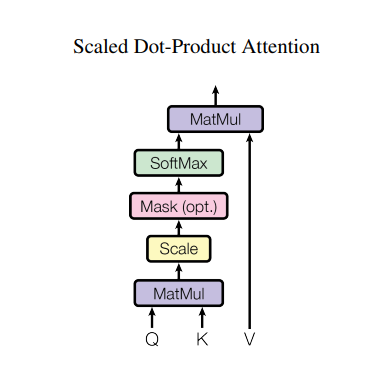

Uwagi:

- Zwracam uwagę, że tutaj nie ma pojęcia przestrzeni i wzajemnego położenia, atencja po prostu działa na zbiorze wektorów. Dlatego istotne jest zastosowanie także embeddingu pozycyjnego poszczególnych tokenów.
- Uzyskaliśmy tutaj decoder attention block. To oznacza, że przyszłe tokeny nie mogą wpływać na przeszłe. Po usunięciu działania `tril` uzyskamy encoder attention block, w którym każdy token może wpłynąć na każdy token.
- "auto-uwaga" oznacza, że Keys oraz Values są produkowane z tego samego źródła co Queries. Nie zawsze tak jest, wtedy mówi się o "cross-attention". Autorzy Sami Wiecie Którego badania używali transformera zarówno z self, jak i cross attention. Niemniej w tym notatniku ograniczymy się tylko do self-attention.
- Patrząc na powyższy obrazek widac, że względem atencji opisanej w "Attention is all you need" brakuje nam jednej istotnej rzeczy: skalowania, czyli podzielenia `wei` przez pierwiastek z `head_size`. Jeżeli tego dzielenia zabraknie, to dla dużych head_size mnożenie Queries @ Keys będzie wytwarzało macierze z dużymi wartościami bezwzględnymi. To oznacza, że zastosowanie softmaxu będzie zbiegało do wektorów one-hot a jest to zjawisko bardzo niepożądane, ponieważ oznacza spychanie na dalszy plan części tokenów.
- Chcę także zwrócić uwagę na jeden szczegół: na wymiar Tensora wei. Jego ostatnie dwa wymiary to macierz o wymiarach kontekst X kontekst. To oznacza, że liczba obliczeń wykonywanych w ramach mechanizmu uwagi rośnie kwadratowo wraz ze wzrostem rozmiaru kontekstu! Jest to strasznie nieskalowalne i z tego powodu dla wielu modeli to właśnie rozmiar kontekstu jest wąskim gardłem.



Zaimplementujmy teraz to w postaci Modułu, aby można było korzystać z tego w budowaniu sieci neuronowych. Posługując się terminologią z "Attention is all you need", budujemy teraz jedną Head of Attention (dokładniej to self-attention).

In [180]:
from math import sqrt
class Head(nn.Module):
    def __init__(self, embedding_size, head_size, context_size):
        super().__init__()
        self.sqrt_head_size = sqrt(head_size)
        self.keys = nn.Linear(embedding_size, head_size, bias=False)
        self.queries = nn.Linear(embedding_size, head_size, bias=False)
        self.values = nn.Linear(embedding_size, head_size, bias=False)
        # wykorzystujemy register_buffer, aby jednocześnie zapisać ten Tensor w modelu i wykluczyć go z optymalizacji podczas treningu
        self.register_buffer("tril", torch.tril(torch.ones(context_size, context_size))) 
        
    def forward(self, x):
        k = self.keys(x)
        q = self.queries(x)
        wei = q @ k.transpose(-1, -2)
        # przed wykonaniem softmaxu skalujemy dzieląc przez pierwiastek z head_size
        wei = wei / self.sqrt_head_size
        wei = wei.masked_fill(self.tril == 0, float("-inf"))  
        wei = F.softmax(wei, dim=-1)
        
        v = self.values(x)
        out = wei @ v
        return out
        

Zmodyfikujmy nieco nasz model. Teraz będziemy korzystać z faktycznych Embeddingów - każdy z tokenów będziemy zamieniać na zbiór liczb, które docelowo mają reprezentować jego znaczenie. Tutaj już skorzystamy z warstwy nn.Embedding, aby nie spowalniać treningu. 

Zamiana tokenu na zbiór liczb (który niekoniecznie jest takiego wymiaru jak całe słownictwo, zazwyczaj jest dużo mniejszy!) oznacza, że samo spojrzenie w lookup-table nie będzie już nam zapewniało logitów / prawdopodobieństw. To oznacza, że za warstwą nn.Embedding trzeba umieścić warstwę liniową, która zamieni embedding tokenu na faktyczne logity. Nazwiemy ją model_head.


In [181]:
class BigramModel2(nn.Module):
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        self.self_attention_head = Head(n_embd, head_size, context_size=context_size)
        self.model_head = nn.Linear(head_size, vocab_size)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.self_attention_head(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
            

Spróbujmy wygenerować coś z naszego, teraz już wykorzystującego self-attention, modelu:

In [182]:
def try_model_generation(model_class, n_embd = 32, train_iterations=2500, context_size=7):
    
    model_instance = model_class(vocab_size=vocab_size, n_embd=n_embd, head_size=18)
    model_instance = model_instance.to(device)
    xb, _ = get_random_batch("train", batch_size, context_size, rng)
    xb = xb.to(device)
    train_model(model_instance, train_iterations, context_size=context_size)
    generated_output = model_instance.generate(xb, 500)[0].cpu()
    print(2 * "\n")
    print(f"Generated 500 new tokens, output shape: {generated_output.shape}")
    print(20*"-" + "\n" + f"Generated text: {decode(generated_output.tolist())}")   
    
if train_older_models is True:
    try_model_generation(BigramModel2)

Iteration 1 train loss: 4.267 | test loss: 4.261
Iteration 251 train loss: 2.959 | test loss: 2.865
Iteration 501 train loss: 2.654 | test loss: 2.688
Iteration 751 train loss: 2.626 | test loss: 2.575
Iteration 1001 train loss: 2.643 | test loss: 2.485
Iteration 1251 train loss: 2.533 | test loss: 2.491
Iteration 1501 train loss: 2.539 | test loss: 2.430
Iteration 1751 train loss: 2.438 | test loss: 2.400
Iteration 2001 train loss: 2.398 | test loss: 2.425
Iteration 2251 train loss: 2.546 | test loss: 2.405
Final iteration train loss: 2.404 | test loss: 2.333



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text: se reel ho apn:
BAy ye, moom othes the vold aces't
CENV--ZIGKome to e:
s, hun m'd ve st dlde ballkig ll,
Reantheas thereaee, you fgrit te ind yo ly rd,
Whanghrender thorplis ave I as
bicer gposrtith ia kesh!
Band
Bennd ald
Nod SI: nli wipnd--h'shtu ghe the ssepren heratourpril:
Ave hancilor and hs?
Bel,
by sans hangat
RUUSuge ansowt 

Widać pewien postęp... teraz ten tekst układem nieco przypomina faktycznego Szekspira. Jednak to nadal "nie jest to". Nasza Atencja na pewno przynosi "jakieś" efekty, jednak aby uzyskać sensowny tekst czeka nas jeszcze wiele pracy.

W "Attention is all you need" też zauważono, że jest to zbyt mało. Dlatego to, co teraz zbudowaliśmy, czyli Head of Attention, to tylko blok, taki klocek Lego, z których zbudowano MultiHeadAttention. Polega to na równoległym wykonaniu wielu takich atencji jak ta powyżej, w self_attention_example(), i złączenie ich rezultatów.

Stwórzmy teraz Moduł, który zawiera wiele pojedyńczych "głów" (nie wiem jak lepiej to przetłumaczyć) i w metodzie forward() złączmy wyniki z każdej pojedyńczej głowy

In [183]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, embedding_size:int, head_size: int, context_size: int, num_heads: int):
        super().__init__()
        self.heads = nn.ModuleList([Head(embedding_size, head_size, context_size) for _ in range(num_heads)])
        
    def forward(self,x):
        # łączymy rezultaty w ostatnim wymiarze. Tworząc wiele głów, na przykład 4, zmniejszamy proporcjonalnie wymiar
        # każdej z nich. Wtedy łącząc ich rezultaty w ostatnim wymiarze uzyskamy taki sam wymiar jak przy pojedyńczej Head
        return torch.cat([single_head(x) for single_head in self.heads], dim=-1)

Zaimplementujmy to w kolejnej generacji naszego modelu:

In [184]:
class BigramModel3(nn.Module):
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        how_many_heads = 4
        single_head_size = head_size // how_many_heads  # musi być całkowity
        self.self_attention_heads = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=how_many_heads)

        self.model_head = nn.Linear(how_many_heads * single_head_size, vocab_size)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.self_attention_heads(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
if train_older_models is True:
    try_model_generation(BigramModel3)

Iteration 1 train loss: 4.164 | test loss: 4.178
Iteration 251 train loss: 3.012 | test loss: 3.011
Iteration 501 train loss: 2.735 | test loss: 2.673
Iteration 751 train loss: 2.591 | test loss: 2.489
Iteration 1001 train loss: 2.468 | test loss: 2.632
Iteration 1251 train loss: 2.359 | test loss: 2.411
Iteration 1501 train loss: 2.352 | test loss: 2.461
Iteration 1751 train loss: 2.466 | test loss: 2.372
Iteration 2001 train loss: 2.388 | test loss: 2.410
Iteration 2251 train loss: 2.295 | test loss: 2.443
Final iteration train loss: 2.422 | test loss: 2.260



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text:  pupil-tainnescancua.

Fet the.

Cores':
Ye,
Cels, wp-oay fy nowl
ARace, racowlfake thas udhe rear, the onaths isyour, fimed not is cees ger
Fe wour the favibocs whe the ble thod he is gak
He ode weme an&d baug!
 to is ansn her.

Whe ping;
And so cuir allallle wa cwhis ofetu
Sly nor us. hey lit swe,
Asscl suncek me't pongir and they 

To nadal nie to... czegoś nam brakuje. Według autorów "Attention is all you need" brakuje nam warstwy Linear na wyjściu z MultiHeadAttention. Można to próbować interpretować w taki sposób, że tokeny "rozmawiają" ze sobą w procesie atencji, jednak to nie jest wystarczające. Teraz, gdy już ze sobą "porozmawiały", muszą przetworzyć zdobyte informacje. Dlatego zwieńczymy nasz model warstwą FeedForward. Typowym rozwiązaniem w takiej sytuacji jest użycie zwykłej warstwy Linear i zwieńczenie jej funkcją aktywacji, zazwyczaj ReLU. Jednak autorzy "attention is all you need" użyli nieco innej struktury:

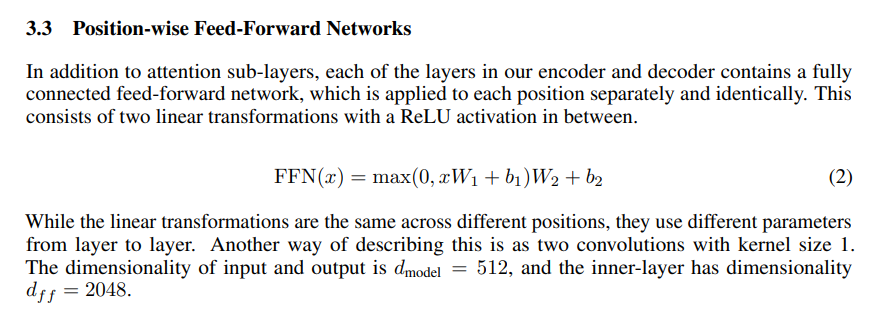




Ta warstwa przetwarza każdy z tokenów indywidualnie, nie dochodzi już do komunikacji pomiędzy nimi

In [185]:
class FeedForward(nn.Module):
    def __init__(self, n:int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, n * 4),
            nn.ReLU(),
            nn.Linear(n * 4, n)
        )
    def forward(self, x):
        return self.net(x)
        

In [186]:
class BigramModel4(nn.Module):
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        how_many_heads = 4
        single_head_size = head_size//how_many_heads
        self.self_attention_heads = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=how_many_heads)
        self.ffwd = FeedForward(single_head_size * how_many_heads)  # dodajemy dodaktową wartstwę Linear, nie zmienia wymiarów
        self.model_head = nn.Linear(single_head_size * how_many_heads, vocab_size)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.self_attention_heads(x)
        # przepuszczamy embeddingi przez wartstwę FeedForward
        x = self.ffwd(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
if train_older_models is True:
    try_model_generation(BigramModel4)

Iteration 1 train loss: 4.201 | test loss: 4.191
Iteration 251 train loss: 2.848 | test loss: 2.847
Iteration 501 train loss: 2.540 | test loss: 2.727
Iteration 751 train loss: 2.616 | test loss: 2.493
Iteration 1001 train loss: 2.474 | test loss: 2.542
Iteration 1251 train loss: 2.464 | test loss: 2.442
Iteration 1501 train loss: 2.383 | test loss: 2.449
Iteration 1751 train loss: 2.384 | test loss: 2.415
Iteration 2001 train loss: 2.447 | test loss: 2.566
Iteration 2251 train loss: 2.495 | test loss: 2.513
Final iteration train loss: 2.508 | test loss: 2.408



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text: t dignitie ononn' shre, hincn the metrile tus abrarl ofrikke drlangthet ich 'sh gath you, thih adsr'd bas thr.

WEFS:
Ho hew shiek o Wasif wres me;
I hor brat,
And chy to fro dithe ho lost, thae you,
Sowis mur at And ture
Oo ufour prerd:
I
Att ide:
A froop ast.

YOou he's blus
Aot thpt, dre hid;
Horss bund,
Gord
Fro ond wo teif,
Ach 

Tekst może nie wygląda lepiej, jednak loss naszego modelu jest nieco mniejszy - dobra nasza. 

Teraz, gdy już zaimplementowaliśmy fazę komunikacji (attention) oraz obliczeń (feed forward), zamknijmy je w jeden "Block" i powtórzmy kilka razy, przeplatając komunikację i obliczenia.

In [187]:
class Block(nn.Module):
    """Blok w którym najpierw następuje komunikacja (self-attention) a potem obliczenia (feed forward)"""
    def __init__(self, n_embd, n_head):
        super().__init__()
        single_head_size = n_embd // n_head
        self.sa = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=n_head)
        self.ffwd = FeedForward(single_head_size * n_head)
        
    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x


In [188]:
class BigramModel5(nn.Module):
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        how_many_heads = 4
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        self.model_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.blocks(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
if train_older_models is True:
    try_model_generation(BigramModel5)

Iteration 1 train loss: 4.189 | test loss: 4.174
Iteration 251 train loss: 3.085 | test loss: 3.044
Iteration 501 train loss: 2.795 | test loss: 2.749
Iteration 751 train loss: 2.677 | test loss: 2.496
Iteration 1001 train loss: 2.581 | test loss: 2.545
Iteration 1251 train loss: 2.462 | test loss: 2.581
Iteration 1501 train loss: 2.543 | test loss: 2.401
Iteration 1751 train loss: 2.430 | test loss: 2.269
Iteration 2001 train loss: 2.225 | test loss: 2.313
Iteration 2251 train loss: 2.329 | test loss: 2.258
Final iteration train loss: 2.218 | test loss: 2.211



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text: ook thy mimh'd a plistsk sef I ceand, culdt labs:
Thind saut of vay?

BESYHILS 
eput ned be grensave woug rorowg ous; bigt, com bomhens. Useet yoice ar; be not we ny'd: dound hing to asl for tou bec se, knonter ctron porpeven's somclto to to hy fere, slust.

Fher gelave nos bot,
Al
Nughd thandigen
We oned pe,
o mense lon'd amuingd je

Nasza sieć wcale nie radzi sobie lepiej, tylko gorzej! Dlaczego? 
Zwielokratniając liczbę Bloków sprawiliśmy, że ta sieć staje się dość głęboka, a przez to cierpi na problemy optymalizacyjne głębokich sieci. Autorzy "Attention is all you need" oczywiście o tym pomyśleli, więc nie będę wymyślał koła od nowa, tylko skopiuję ich pomysł :)

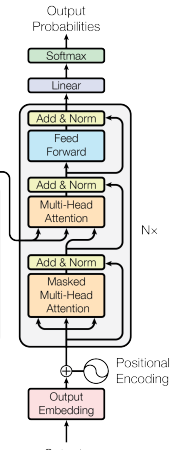

Pierwszym problemem jest to, że gradient musi "przejść" przez bardzo wiele różnych warstw przez to, że nasza sieć jest głęboka i to utrudnia jej trening.

Rozwiązaniem są "skróty", które na tym diagramie omijają bloki Attention oraz Feed Forward. Tworzą one dużo krótszą drogę dla gradientu, która bardzo ułatwia optymalizowanie głębokich sieci. Z angielska takie "autostrady" nazywają się **residual connections** i po raz pierwszy zostały szeroko zastosowane w 2015 roku.

Operacja dodawania równo rozdziela gradient pomiędzy oba operandy, dlatego to właśnie jej użyjemy do zaimplementowania tych skrótów.
W kodzie następnego modelu oznaczę te skróty komentarzami, ponieważ nie wiedząc skąd dokładnie się biorą na pierwszy (oraz drugi) rzut oka mogą nie mieć żadnego sensu.

Zainteresowanych odsyłam do artykułu, który moim zdaniem dobrze to tłumaczy: https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55

Aby to zaimplementować musimy zmienić definicje klasy Block:


In [189]:
   
class Block2(nn.Module):
    """Blok zmodyfikowany o dodatkowe residual connection"""
    def __init__(self, n_embd, n_head):
        super().__init__()
        single_head_size = n_embd // n_head
        self.sa = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=n_head)
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x =  x + self.sa(x)  # Res connection: x + F(x)
        x =  x + self.ffwd(x)  # Res connection: x + F(x)
        return x
    

In [190]:
class BigramModel6(nn.Module):
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        how_many_heads = 4
        self.blocks = nn.Sequential(
            Block2(n_embd, n_head=4),
            Block2(n_embd, n_head=4),
            Block2(n_embd, n_head=4)
        )
        self.model_head = nn.Linear(n_embd, vocab_size)

    # noinspection PyPep8Naming
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.blocks(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
if train_older_models is True:
    try_model_generation(BigramModel6)

Iteration 1 train loss: 4.531 | test loss: 4.560
Iteration 251 train loss: 2.520 | test loss: 2.495
Iteration 501 train loss: 2.359 | test loss: 2.327
Iteration 751 train loss: 2.197 | test loss: 2.256
Iteration 1001 train loss: 2.251 | test loss: 2.180
Iteration 1251 train loss: 2.137 | test loss: 2.141
Iteration 1501 train loss: 2.179 | test loss: 2.111
Iteration 1751 train loss: 2.034 | test loss: 2.144
Iteration 2001 train loss: 2.025 | test loss: 2.052
Iteration 2251 train loss: 2.033 | test loss: 1.985
Final iteration train loss: 2.078 | test loss: 1.961



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text:  lastingenan reak re his came a this lave! Sasme or son:
That,
Doub that my ain's hus deatesoner ques is that them ysalnspaics frip put in at a you of not sir infor how

jowtay,
Tacides: 'tway and the renguin, agat igking tor rice not
As he ins ans prough ven sprough riststernces rely, your me lork in ort
Ane on! dut holds of rour lo

Tekst nadal nie wygląda idealnie, jednak widać postęp. Ponadto istotnie zmniejszyliśmy loss naszego modelu, co pokazuje, że zmierzamy w dobrą stronę.

Teraz pora zająć się kolejnym problemem typowym szczególnie dla dla głębokich sieci neuronowych - eksplodującym i/lub znikającym
gradientem. Rozwiązaniem jest normalizacja, która sprawia, że wartości gradientów "pozostają pod kontrolą".

Najpopularniejsze są dwa rodzaje normalizacji - BatchNorm oraz LayerNorm. BatchNorm jest często używany przy computer vision, na przykład w sieciach CNN. Niemniej ma on swoje cechy, które przy zastosowaniach w NLP okazują się wadami:

- Jest zależny od całego batcha. To sprawia, że różne przykłady w jednym batchu wzajemnie wpływają na to, jak są znormalizowane. 
- Z powodu zależności od całego batcha jest bardzo wrażliwy na rozmiar tego batcha: małe rozmiary prowadzą do słabych oszacowań średniej i wariancji
- Dobrze sobie radzi w miejscach, gdzie istotna okazuje się zależność przestrzenna, jak np. przy analizie obrazów

ALternatywnym podejściem jest LayerNorm. Normalizuje wejścia dla każdego przykładu oddzielnie.

- Każda próbka jest normalizowana niezależnie od pozostałych
- Nie jest wrażliwy na rozmiar batcha, ponieważ każdy sample jest normalizowany niezależnie
- Nie uwzględnia żadnych zależności przestrzennych między próbkami, przez co dobrze sobie radzi w przetwarzaniu sekwencji oraz NLP

Po tym porównaniu pewnie nikogo nie zdziwi, że autorzy Attention is all you need skorzystali z LayerNorm. LayerNorm oczywiście jest wbudowany w PyTorch, jednak obiecałem budowanie od podstaw... Podczas LayerNorm realizujemy nastepującą operację:

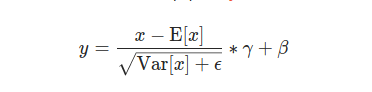

In [191]:
from typing import Tuple, List
class MyLayerNorm(nn.Module):
    """Warstwa normalizująca po ostatnich wymiarach podanego Tensora"""
    normalized_shape: Tuple[int] | List[int]
    def __init__(self, normalized_shape: Tuple[int] | List[int], eps=1e-5, elementwise_affine=True, bias=True):
        """
        :param normalized_shape: Wymiary, po których ma zostać przeprowadzona normalizacja. Muszą to być ostatnie wymiary podanego 
            Tensora. Są potrzebne, jeżeli warstwa ma uczyć się dodatkowo wag (dla wbudowanej w torch jest to parametr 
            elementwise_affine = True). My nie będziemy tego tutaj używać
        """
        super().__init__()
        self.normalized_shape = normalized_shape
        if elementwise_affine is True:
            self.gamma = nn.Parameter(torch.ones(normalized_shape))
            if bias is True: 
                self.beta = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        self.bias = bias
        
   
    def forward(self, x: torch.Tensor):
        ndim = len(self.normalized_shape)
        if tuple(x.shape[-ndim:]) != tuple(self.normalized_shape):
            raise ValueError(f"Expected last dimensions to have shape {self.normalized_shape}, got {x.shape[-ndim:]}")
        temp = [i for i in range(-ndim, 0)]
        mean = x.mean(dim=temp, keepdim=True)
        var = x.var(dim=temp, unbiased=False, keepdim=True) # wbudowana w PyTorch implementacja korzysta z obciążonego estymatora,
        # więc my także będziemy
        x = (x - mean) / torch.sqrt(var + self.eps)
        if self.elementwise_affine is True:
            x = x * self.gamma
            if self.bias is True:
                x = x + self.beta
        return x


# noinspection PyPep8Naming
def compare_layer_norms():
    # NLP example
    batch, length, emb_dim = 20, 5, 10
    emb = torch.randn(batch, length, emb_dim)
    torch_norm = nn.LayerNorm(emb_dim, elementwise_affine=False)
    my_norm = MyLayerNorm((emb_dim, ))
    print(f"Embedding example, are the results the same? :{torch.allclose(torch_norm(emb), my_norm(emb), atol=1e-7)}")  
    
    #Image example
    batch, C, H, W = 20, 5, 10, 10
    image_input = torch.randn(batch, C, H, W)
    torch_norm = nn.LayerNorm([C, H, W], elementwise_affine=False)
    my_norm = MyLayerNorm([C, H, W], elementwise_affine=False)
    print(f"Image example, are the results the same? :{torch.allclose(torch_norm(image_input), my_norm(image_input), atol=1e-7)}")  

compare_layer_norms()

Embedding example, are the results the same? :True
Image example, are the results the same? :True


Jak widać nasza własna warstwa MyLayerNorm zwraca identyczne wyniki jak wbudowana w torch LayerNorm.

Zaimplementujmy teraz LayerNorm w naszym modelu. Jak widać na załączonym nieco wyżej diagramie autorzy Attention is all you need używają LayerNorm po każdej warstwie Attention i FeedForward. To oznacza, że znowu zmieniamy definicję klasy Block. LayerNorm jest także na samym końcu transformera, tuż przed ostatnią warstwą Linear.

W klasie Block dodamy także zabezpieczenie sprawdzające, czy n_embd można podzielić przez n_head

In [192]:
class Block3(nn.Module):
    """Blok z dodanym LayerNorm"""
    def __init__(self, n_embd, n_head, context_size):
        super().__init__()
        if n_embd % n_head != 0:
            error_msg = (f"Class Block expected n_embd to be divisible by n_head, but got {n_embd = } and {n_head = }"
                         f"which leaves remainder of {n_embd % n_head}.")
            raise ValueError(error_msg)
        single_head_size = n_embd//n_head
        self.sa = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=n_head)
        self.ffwd = FeedForward(n_embd)
        self.layer_norm1 = MyLayerNorm([n_embd])
        self.layer_norm2 = MyLayerNorm([n_embd])
        
    def forward(self, x):
        x = x + self.sa(self.layer_norm1(x))  # Res connection: x + F(x)
        x = x + self.ffwd(self.layer_norm2(x))  # Res connection: x + F(x)
        return x
class BigramModel7(nn.Module):
    """ Dodano LayerNorm"""
    def __init__(self, n_embd: int, vocab_size: int, head_size: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        self.blocks = nn.Sequential(
            Block3(n_embd, n_head=4, context_size=context_size),
            Block3(n_embd, n_head=4, context_size=context_size),
            Block3(n_embd, n_head=4, context_size=context_size),
            MyLayerNorm([n_embd]),
        )
        self.model_head = nn.Linear(n_embd, vocab_size)

    # noinspection PyPep8Naming
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.blocks(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
train_older_models = True   
if train_older_models is True:
    try_model_generation(BigramModel7)

Iteration 1 train loss: 4.202 | test loss: 4.203
Iteration 251 train loss: 2.562 | test loss: 2.525
Iteration 501 train loss: 2.294 | test loss: 2.382
Iteration 751 train loss: 2.235 | test loss: 2.268
Iteration 1001 train loss: 2.309 | test loss: 2.172
Iteration 1251 train loss: 2.175 | test loss: 2.095
Iteration 1501 train loss: 2.241 | test loss: 2.169
Iteration 1751 train loss: 2.132 | test loss: 2.125
Iteration 2001 train loss: 1.961 | test loss: 2.045
Iteration 2251 train loss: 2.100 | test loss: 2.042
Final iteration train loss: 2.098 | test loss: 2.051



Generated 500 new tokens, output shape: torch.Size([507])
--------------------
Generated text:  beck?

Fy for word, thee:
Oly tis:
Hem blothere; hill now raiselvex, leacitharanced me :epooth, Of eif lessind, the poterse. Wroun in hath and jefore
As rep, he lood Cvinast lienders,
Whe and onan butiele hour, rle of rettlem;
Alive hor olliud to corsons this have afs:
Mortack?

DUKINGA:
Nod, voin,
Or hange from are! I fruck-uncom.


Po dodaniu normalizacji loss trochę się obniżył - dobra nasza. Na razie ta zmiana może się wydawać nieznaczna, ale będzie odgrywała istotniejszą rolę, gdy będziemy dalej powiększali naszą sieć.

Gdy zajęliśmy się już dwoma "najpopularniejszymi" problemami sieci głębokich możemy spróbować powiększyć nasz model i zobaczyć, jak się sprawdzi. W celu powiększenia modelu musimy go jeszcze raz zredefiniować, aby można było dynamicznie określać liczbę warstw Block.

In [194]:
# Redefinicja hiperparametrów
batch_size = 64
context_size = 128
train_iterations = 3_000
learning_rate = 5e-4  # zmniejszamy lr, ponieważ nasz model będzie większy
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_size = 192
amount_of_heads = 6
amount_of_blocks = 4
dropout = 0.1  # będzie potrzebny za chwilę

rng = torch.Generator()
rng.manual_seed(42)


# noinspection PyPep8Naming
class BigramModel8(nn.Module):
    """ Dodano dynamiczne ustalanie liczby warstw Block"""
    def __init__(self, n_embd: int, vocab_size: int, head_size):  # head size jest już nieużywany ale
        # nie chcę modyfikować funkcji wywołujących starsze modele
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        blocks_list = [Block3(n_embd, amount_of_heads, context_size) for _ in range(amount_of_blocks)]
        blocks_list.append(MyLayerNorm([n_embd]))
        self.blocks = nn.Sequential(*blocks_list)
        self.model_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # przeprowadzamy self-attention
        x = self.blocks(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
if train_older_models is True:
    try_model_generation(BigramModel8, train_iterations=train_iterations, n_embd=embedding_size, context_size=context_size)


Iteration 1 train loss: 3.643 | test loss: 3.660
Iteration 301 train loss: 1.949 | test loss: 1.999
Iteration 601 train loss: 1.587 | test loss: 1.621
Iteration 901 train loss: 1.487 | test loss: 1.496
Iteration 1201 train loss: 1.418 | test loss: 1.404
Iteration 1501 train loss: 1.367 | test loss: 1.347
Iteration 1801 train loss: 1.313 | test loss: 1.293
Iteration 2101 train loss: 1.258 | test loss: 1.284
Iteration 2401 train loss: 1.228 | test loss: 1.261
Iteration 2701 train loss: 1.184 | test loss: 1.207
Final iteration train loss: 1.173 | test loss: 1.235



Generated 500 new tokens, output shape: torch.Size([628])
--------------------
Generated text:  not heard speak of Mariana, the sister of
Frederick the great soldier who miscarried at sea?

ISABELLA:
I have heard of the ladies off Exceen,
And statey on conduct of night, and helping his
And but to the Lady Bray lie Salisbury at the deputy;
What least mistakes, and delish, thou nature,
Beater thou the office: I'll what lost
I kn

**Sukces!** Udało nam się wygenerować tekst, który faktycznie wygląda jak dzieło Szekspira i nawet całkiem nieźle udaje, że ma jakiś sens.
Nasz model nie jest nawet aż taki duży, więc jeszcze nie nastąpił overfitting. Niemniej przy budowaniu większych modeli na większych zbiorach danych prędzej czy później overfitting wystąpi, dlatego zawczasu dodamy do naszego modelu warstwy Dropout, opisane po raz pierwszy w 2014 roku: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf . To właśnie to badanie zacytowali autorzy "Attention is all you need" gdy wprowadzali dropout w swoich modelach.

Dropout jest techniką regularyzacji, która podczas treningu z pewnym prawdopodobieństwem `p` zeruje pewne neurony, przy każdej iteracji inne. W efekcie symulujemy sytuację, w której nie ćwiczymy jednej wielkiej sieci, tylko bardzo dużo subsetów mniejszych sieci, które dopiero przy faktycznej inferencji łączą swoje rezultaty i działają jak jedna sieć:

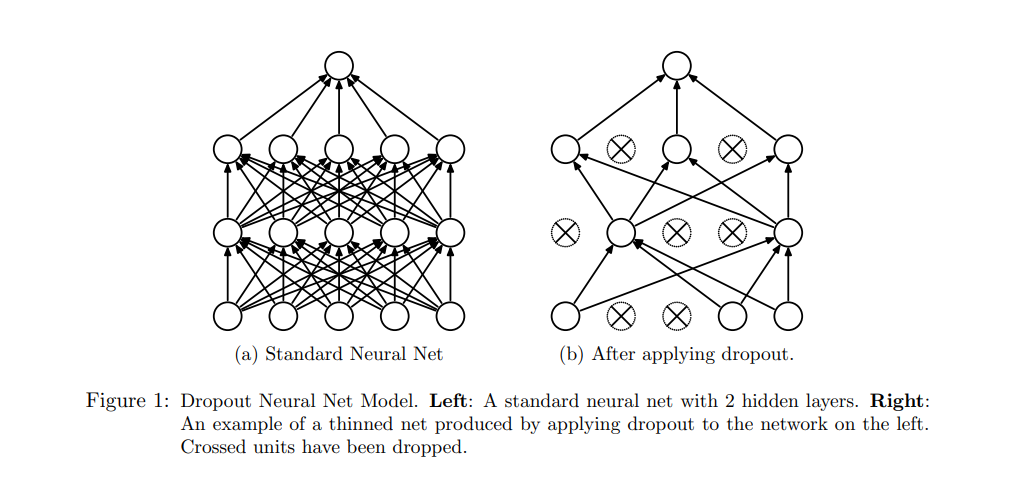

Autorzy "Attention is all you need" dokładnie opisali, w jaki sposób używali u siebie dropout:
> "We apply dropout to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of
Pdrop = 0.1."  

Warto zaznaczyć, że Dropout z prawdopodobieństwem 0.1 to w większości zastosowań wcale nie jest dużo. Niemniej już z takim niewielkim parametrem dropout okazał się bardzo istotny, gdy twórcy Wszyscy Wiemy Którego badania trenowali duże modele

Jak widać dropout jest stosowany tuż przed połączeniem residual pathways ("before it is added to the sub-layer input..."). To oznacza, że musimy zredefiniować naszą klasę Block, znowu... Dropout należy także dodać przy obliczaniu embeddingów, zanim wrzucimy je do Blocków, więc redefiniujemy także nasz model.

Od razu zaznaczę, że w tym momencie istotne jest, aby pamiętać o tym, że warstwy Dropout inaczej zachowują się, gdy model jest w trybie train() a inaczej, gdy w trybie eval().

In [195]:
class Block4(nn.Module):
    """Blok z dodanymi warstwami Dropout"""
    def __init__(self, n_embd, n_head, context_size):
        super().__init__()
        if n_embd % n_head != 0:
            error_msg = (f"Class Block expected n_embd to be divisible by n_head, but got {n_embd = } and {n_head = }"
                         f"which leaves remainder of {n_embd % n_head}.")
            raise ValueError(error_msg)
        single_head_size = n_embd//n_head
        self.sa = MultiHeadedAttention(n_embd, single_head_size, context_size, num_heads=n_head)
        self.ffwd = FeedForward(n_embd)
        self.layer_norm1 = MyLayerNorm([n_embd])
        self.layer_norm2 = MyLayerNorm([n_embd])
        self.drop = nn.Dropout(p=dropout)
    def forward(self, x):
        x = x + self.drop(self.sa(self.layer_norm1(x)))  # Res connection: x + F(x)
        x = x + self.drop(self.ffwd(self.layer_norm2(x)))  # Res connection: x + F(x)
        return x


# noinspection PyPep8Naming
class BigramModel9(nn.Module):
    """ Dodano dynamiczne ustalanie liczby warstw Block"""
    def __init__(self, n_embd: int, vocab_size: int, head_size):  # head size jest już nieużywany ale
        # nie chcę modyfikować funkcji wywołujących starsze modele
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        blocks_list = [Block4(n_embd, amount_of_heads, context_size) for _ in range(amount_of_blocks)]
        blocks_list.append(MyLayerNorm([n_embd]))
        self.blocks = nn.Sequential(*blocks_list)
        self.model_head = nn.Linear(n_embd, vocab_size)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, input_indices):
        B, T = input_indices.shape
        token_emb = self.token_embedding_table(input_indices) # B, T, C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        # automatyczny broadcasting pozwala dodać tensory (B,T,C) i (T,C)
        x = token_emb + pos_emb
        # dodajemy dropout po policzeniu sumy token embeddings i positional embeddings
        x = self.drop(x)
        # przeprowadzamy self-attention
        x = self.blocks(x)
        # dodajemy dropout przed wejściem do ostatniej warstwy Linear
        x = self.drop(x)
        # zamieniamy embeddingi na logity
        logits = self.model_head(x)
        return logits
         
    def generate(self, current_context: torch.Tensor, max_new_tokens: int):
        """
        Metoda przyjmuje kontekst i na jego podstawie generuje `max_new_tokens` nowych tokenów.
        :param current_context: Tensor o wymiarach (Batch, czas) gdzie 'czas' to kolejne znaki kontekstu
        :return: Tensor o wymiarach (Batch, czas + max_new_tokens) zawierający podany kontekst, a do niego "doklejoną"
            wygenerowaną treść
        """
        for _ in range(max_new_tokens):
            # korzystamy z tabeli Embeddingów, więc musimy podać co najwyżej ostatnie context_size znaków
            logits = self(current_context[:, -context_size:])
            logits = logits[:, -1, :]  
            probabilities = F.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probabilities, num_samples=1)
            current_context = torch.cat((current_context, idx_next), dim=1) # (Batch, czas + 1)
        return current_context
    
try_model_generation(BigramModel9, train_iterations=train_iterations, n_embd=embedding_size, context_size=context_size)

Iteration 1 train loss: 3.730 | test loss: 3.752
Iteration 301 train loss: 2.075 | test loss: 2.072
Iteration 601 train loss: 1.711 | test loss: 1.708
Iteration 901 train loss: 1.579 | test loss: 1.540
Iteration 1201 train loss: 1.503 | test loss: 1.490
Iteration 1501 train loss: 1.421 | test loss: 1.386
Iteration 1801 train loss: 1.387 | test loss: 1.342
Iteration 2101 train loss: 1.363 | test loss: 1.303
Iteration 2401 train loss: 1.321 | test loss: 1.347
Iteration 2701 train loss: 1.288 | test loss: 1.302
Final iteration train loss: 1.281 | test loss: 1.265



Generated 500 new tokens, output shape: torch.Size([628])
--------------------
Generated text: treet cry Romeo,
Some Juliet, and some Paris; and all run,
With open outcry toward our monument.

PRINCE:
What fear is this which cold it it: all.
And lay he would my bad degarned me mine.
To meetizens the liwe and conweeding's noble
And help: the shorten and the brood forth, when
When he would wit me from deed: here concrecry, and
p

Teraz w kolejnym Notatniku, `GPT_inference.ipynb`, uruchomię i przetrenuję większy model.